In [52]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

df = pd.read_csv('data/ExoTrain.csv')

In [53]:
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
1,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
2,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
3,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
4,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16


In [54]:
labels = df.LABEL
df = df.drop('LABEL',axis=1)


In [38]:
def stats_plots(df):
    
    #caclulating different statistical measures
    means = df.mean(axis=1)
    medians = df.median(axis=1)
    std = df.std(axis=1)
    maxval = df.max(axis=1)
    minval = df.min(axis=1)
    skew = df.skew(axis=1)
    
    #plotting 
    fig = plt.figure(figsize=(12,8))
    
    ax = fig.add_subplot(2,3,1)
    ax.hist(means,alpha=0.8,bins=50)
    ax.set_xlabel('Mean Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(2,3,2)
    ax.hist(medians,alpha=0.8,bins=50)
    ax.set_xlabel('Median Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(2,3,3)
    ax.hist(std,alpha=0.8,bins=50)
    ax.set_xlabel('Intensity Standard Deviation')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(2,3,4)
    ax.hist(maxval,alpha=0.8,bins=50)
    ax.set_xlabel('Maximum Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(2,3,5)
    ax.hist(minval,alpha=0.8,bins=50)
    ax.set_xlabel('Minimum Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(2,3,6)
    ax.hist(skew,alpha=0.8,bins=50)
    ax.set_xlabel('Intensity Skewness')
    ax.set_ylabel('Num. of Stars')


In [39]:
def stats_plots_with_label(df):
    
    #caclulating different statistical measures seperately for the two classes

    means1 = df[labels==1].mean(axis=1)
    medians1 = df[labels==1].median(axis=1)
    std1 = df[labels==1].std(axis=1)
    maxval1 = df[labels==1].max(axis=1)
    minval1 = df[labels==1].min(axis=1)
    skew1 = df[labels==1].skew(axis=1)
    
    
    
    means2 = df[labels==2].mean(axis=1)
    medians2 = df[labels==2].median(axis=1)
    std2 = df[labels==2].std(axis=1)
    maxval2 = df[labels==2].max(axis=1)
    minval2 = df[labels==2].min(axis=1)
    skew2 = df[labels==2].skew(axis=1)
    
    fig = plt.figure(figsize=(12,8))
    
    ax = fig.add_subplot(231)
    ax.hist(means1,alpha=0.8,bins=50,color='b',normed=True,range=(-250,250))
    ax.hist(means2,alpha=0.8,bins=50,color='r',normed=True,range=(-250,250))
    ax.get_legend()
    ax.set_xlabel('Mean Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(232)
    ax.hist(medians1,alpha=0.8,bins=50,color='b',normed=True,range=(-0.1,0.1))
    ax.hist(medians2,alpha=0.8,bins=50,color='r',normed=True,range=(-0.1,0.1))
    ax.get_legend()
    ax.set_xlabel('Median Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(233)    
    ax.hist(std1,alpha=0.8,bins=50,normed=True,color='b',range=(0,4000))
    ax.hist(std2,alpha=0.8,bins=50,normed=True,color='r',range=(0,4000))
    ax.get_legend()
    ax.set_xlabel('Intensity Standard Deviation')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(234)
    ax.hist(maxval1,alpha=0.8,bins=50,normed=True,color='b',range=(-10000,50000))
    ax.hist(maxval2,alpha=0.8,bins=50,normed=True,color='r',range=(-10000,50000))
    ax.get_legend()
    ax.set_xlabel('Maximum Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(235)
    ax.hist(minval1,alpha=0.8,bins=50,normed=True,color='b',range=(-50000,10000))
    ax.hist(minval2,alpha=0.8,bins=50,normed=True,color='r',range=(-50000,10000))
    ax.get_legend()
    ax.set_xlabel('Minimum Intensity')
    ax.set_ylabel('Num. of Stars')
    
    ax = fig.add_subplot(236)
    ax.hist(skew1,alpha=0.8,bins=50,normed=True,color='b',range=(-40,60))
    ax.hist(skew2,alpha=0.8,bins=50,normed=True,color='r',range=(-40,60)) 
    ax.get_legend()
    ax.set_xlabel('Intensity Skewness')
    ax.set_ylabel('Num. of Stars')



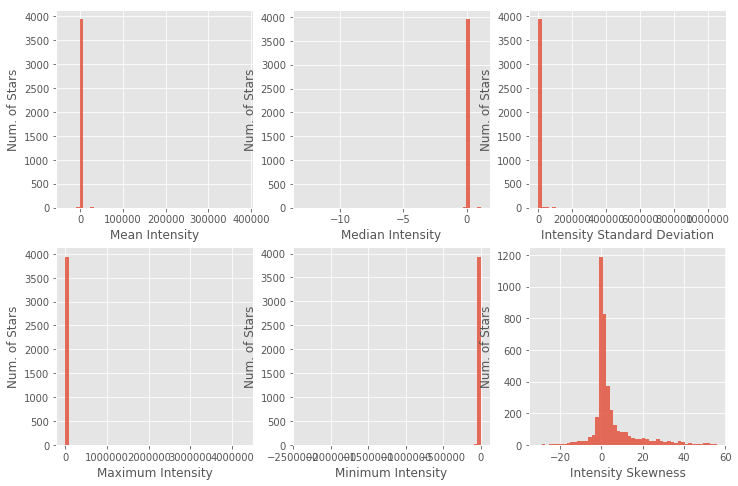

In [40]:
stats_plots(df)
plt.show()

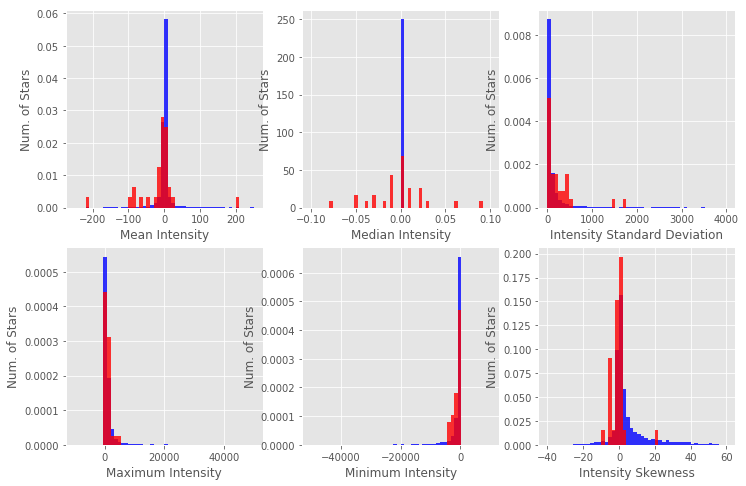

In [41]:
stats_plots_with_label(df)
plt.show()


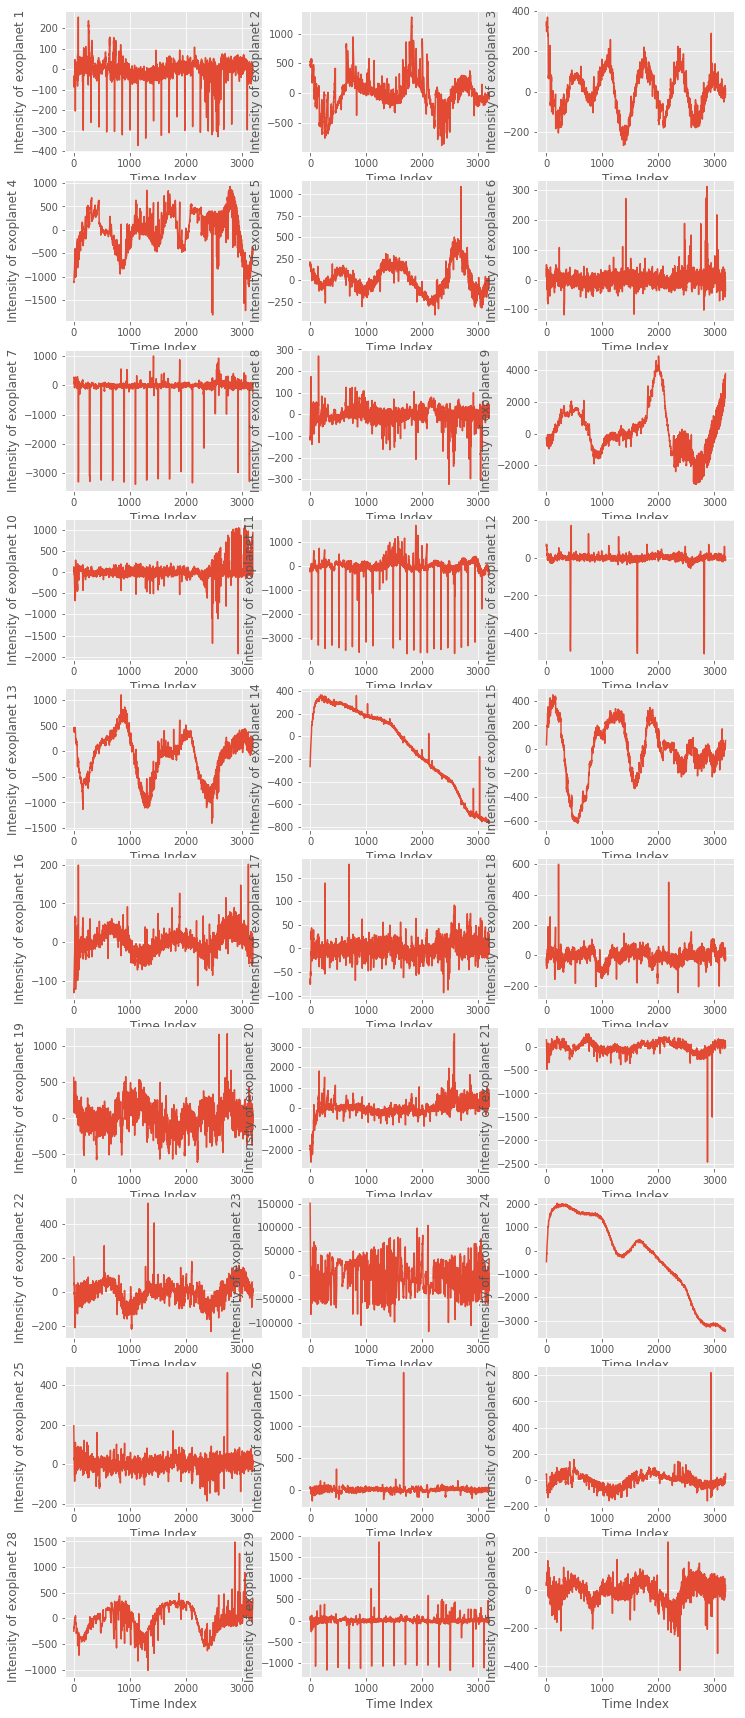

In [45]:
fig = plt.figure(figsize=(12,40))
x = np.array(range(3197))
for i in range(30):
    ax = fig.add_subplot(13,3,i+1)
    ax.plot(x,df[labels==2].iloc[i,:])
    ax.set_ylabel('Intensity of exoplanet {}'.format(i+1))
    ax.set_xlabel('Time Index')

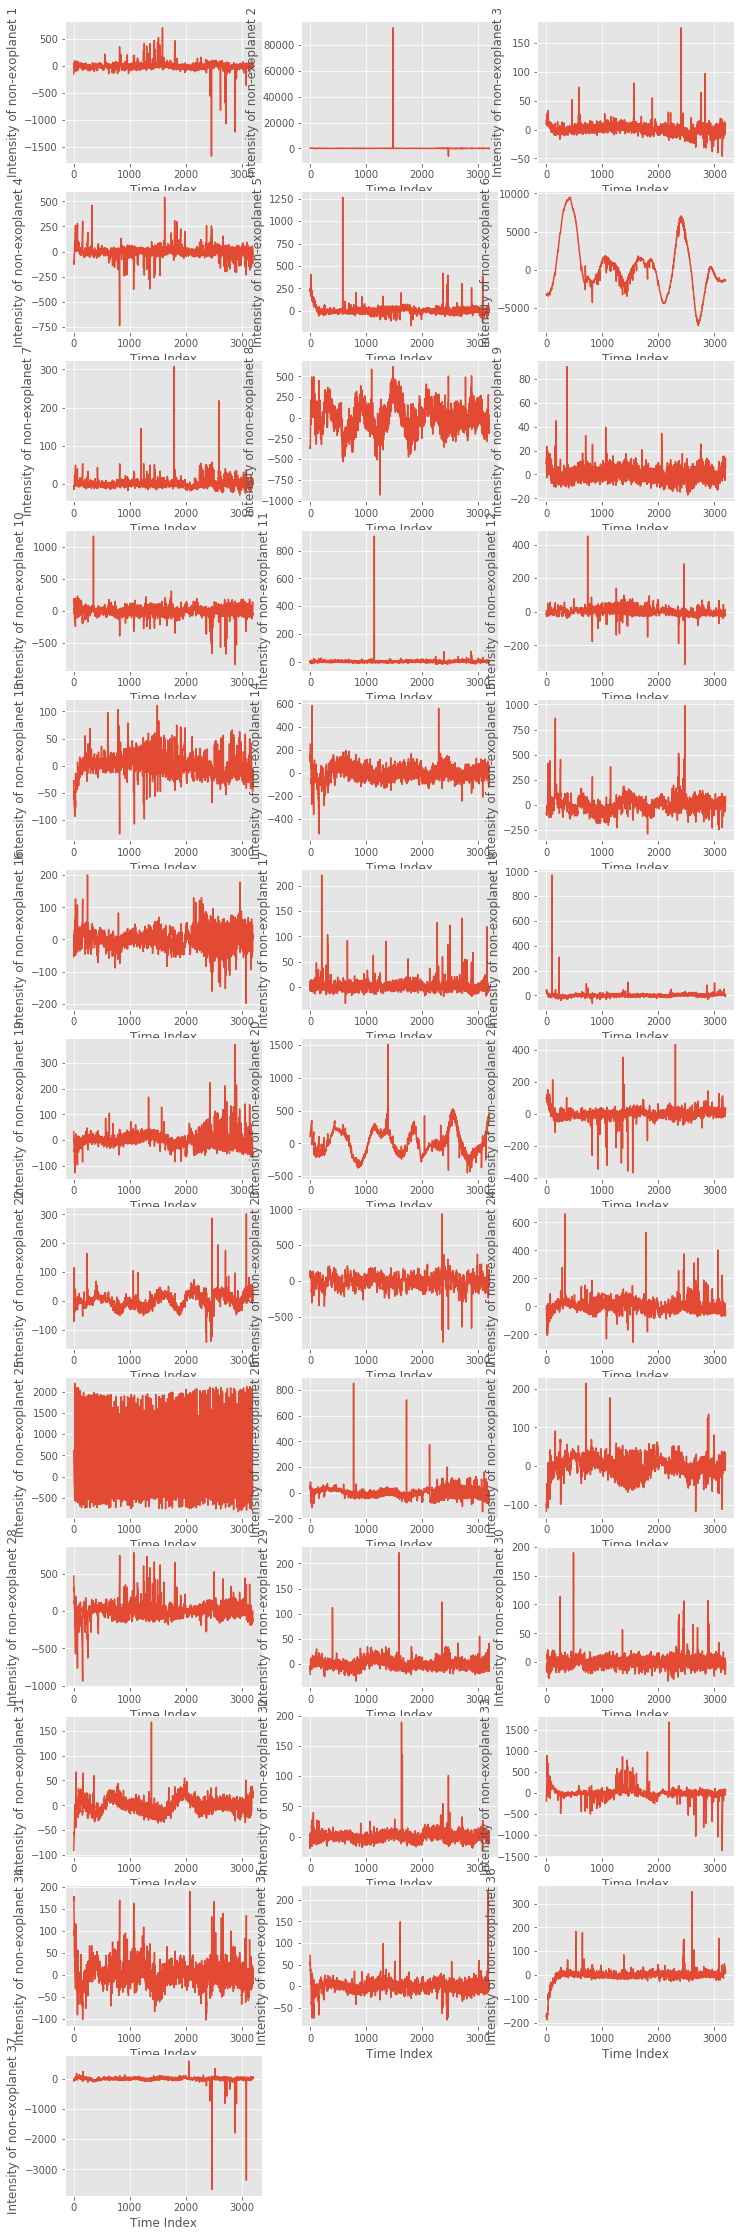

In [46]:
fig = plt.figure(figsize=(12,40))
x = np.array(range(3197))
for i in range(37):
    ax = fig.add_subplot(13,3,i+1)
    ax.plot(x,df[labels==1].iloc[i,:])
    ax.set_ylabel('Intensity of non-exoplanet {}'.format(i+1))
    ax.set_xlabel('Time Index')



# Data Processing

## Outlier Removal



In [50]:
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values:
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
       # print(sorted_values[:30])
        for j in range(remove):
            idx = sorted_values.index[j]
            #print(idx)
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            #print(idx,idx_num)
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX-'+str(idx2)]
                
                count += 1
            new_val /= count # count will always be positive here
            #print(new_val)
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.set_value(i,idx,new_val)
        
            
    return df